In [2]:
library(dplyr)
library(ggplot2)
library(httr)
library(jsonlite)
library(AnnotationDbi)
library(org.Hs.eg.db)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘AnnotationDbi’ was built under R version 4.1.3”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, whi

# EuRBPDB data

In [3]:
### Homo_sapiens
lines <- readLines("/home/ylee/data/Homo_sapiens.RBP.txt")

In [4]:
### Mus_musculus
lines <- readLines("/home/ylee/data/Mus_musculus.RBP.txt")

In [5]:
RBP_list <- lapply(lines, function(line) strsplit(line, "\t")[[1]])
RBP_array <- do.call(rbind, RBP_list)           # convert to an array
RBP_df <- as.data.frame(RBP_array)       

In [6]:
### Homo_sapiens
colnames(RBP_df) <- c("ensembl.gene.id", "gene.symbol", "gene.id", "domains.functions", "synonyms")
EuRBPDB_H = as.vector(RBP_df$ensembl.gene.id)
length(EuRBPDB_H)
write.csv(EuRBPDB_H, file = "/home/ylee/data/EuRBPDB_H.csv", row.names = FALSE)

[1] 2995

In [7]:
### Mus_musculus
colnames(RBP_df) <- c("ensembl.gene.id", "gene.symbol", "gene.id", "synonyms", "gene.description", "domains.functions")
EuRBPDB_M = as.vector(RBP_df$ensembl.gene.id)
length(EuRBPDB_M)
write.csv(EuRBPDB_H, file = "/home/ylee/data/EuRBPDB_M.csv", row.names = FALSE)

[1] 2995

# RBPtoGO data

In [8]:
### Homo_sapiens
lines <- readLines("/home/ylee/data/Table_HS_RBP.txt")

In [9]:
### Mus Musculus
lines <- readLines("/home/ylee/data/Table_MM_RBP.txt")

In [10]:
lines <- gsub("\"", "", lines)

RBP_list <- lapply(lines, function(line) strsplit(line, "\t")[[1]])
RBP_list <- RBP_list[7:length(RBP_list)]
RBP_array <- do.call(rbind, RBP_list)           # convert to an array
RBP_df <- as.data.frame(RBP_array)

colnames(RBP_df) <- RBP_df[1,]
RBP_df <- RBP_df[2:nrow(RBP_df),]

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 3)”


In [11]:
### Homo_sapiens
for (i in 1:nrow(RBP_df)){
    RBP_df$Ensembl_ID[i] <- get_ensembl_id_from_gene_name("human", RBP_df$Gene_Name[i])
}
RBPtoGO_H = as.vector(RBP_df$Ensembl_ID)
head(RBPtoGO_H)

ERROR: Error in get_ensembl_id_from_gene_name("human", RBP_df$Gene_Name[i]): could not find function "get_ensembl_id_from_gene_name"


In [ ]:
### Mus Musculus
for (i in 1:nrow(RBP_df)){
    RBP_df$Ensembl_ID[i] <- get_ensembl_id_from_gene_name("mouse", RBP_df$Gene_Name[i])
}

RBPtoGO_M = as.vector(RBP_df$Ensembl_ID)
head(RBPtoGO_M)

In [ ]:
length(RBPtoGO_H)
write.csv(RBPtoGO_H, file = "/home/ylee/data/RBPtoGO_H.csv", row.names = FALSE)

In [ ]:
length(RBPtoGO_M)
write.csv(RBPtoGO_M, file = "/home/ylee/data/RBPtoGO_M.csv", row.names = FALSE)

# Functions

In [12]:
get_mspec_csv <- function(path, num) {
    lines <- readLines(path)
    lines <- gsub("\"", "", lines)
    data_list <- lapply(lines, function(line) strsplit(line, ",")[[1]])

    longest_row_len = 0;                    
    for (i in data_list){
        if (length(i) > longest_row_len)
            longest_row_len <- length(i)
    }

    filled_data_list <- list()
    for (i in 1:length(data_list)){
        current_row <- data_list[[i]]
        len_diff = longest_row_len - length(current_row)
        if (len_diff > 0) {
            current_row <- c(current_row, rep(NA, len_diff))
        }  
        filled_data_list[[i]] <- current_row
    }

    mspec <- do.call(rbind, filled_data_list)           # convert to an array
    mspec <- as.data.frame(mspec)                       # convert to dataframe
    
    colnames(mspec) <- as.character(unlist(mspec[1, ]))
    mspec <- mspec[-1, ]          # Remove the first row from the data frame
    rownames(mspec) <- NULL             # Reset the row indices

    ### change front 1:num rows in strange annotation
    for (i in 1:num) {
        protein_ids <- mspec$Majority.protein.IDs[i]
        protein_ids_list <- strsplit(protein_ids, ";")
        mspec$name[i] <- protein_ids_list[[1]][1]
    }
    return(mspec)
}

In [13]:
get_accession_num_from_entry_identifier <- function(entry_id) {   # entry identifier -> standard accession number
    url <- paste0("https://rest.uniprot.org/uniprotkb/", entry_id, ".txt")
    response <- GET(url)
    
    if (status_code(response) == 200) {
        content <- httr::content(response, as = "text", encoding="UTF-8")
        accession_line <- grep("AC", strsplit(content, "\n")[[1]], value = TRUE)[1]
        accession_numbers <- gsub("AC\\s+", "", accession_line)
        return(unlist(strsplit(accession_numbers, ";")))
    } else {
        return(NULL)
  }
}

# Example
# entry_ids <- c("A0A023HHL0", "A0A0B4J2E5")
# accessions <- sapply(entry_ids, get_accession)
# print(accessions)

In [14]:
response <- GET("https://rest.uniprot.org/uniprotkb/Q8C650.txt")
content <- httr::content(response, as = "text", encoding="UTF-8")
matches <- regmatches(content, regexpr("ENSMUSP\\d+", content))
print(matches)

[1] "ENSMUSP00000129023"


In [15]:
get_ensembl_id_from_entry_id <- function(species, entry_id) {      # protein_entry -> ensembl_gene_id
    url <- paste0("https://rest.uniprot.org/uniprotkb/", entry_id, ".txt")
    response <- GET(url)
    
    if (status_code(response) == 200) {
        content <- httr::content(response, as = "text", encoding="UTF-8")
        example <- grep("DR   Ensembl", strsplit(content, "\n")[[1]], value = TRUE)
        if (length(example) != 0){
            ensembl_id_subv <- strsplit(example, "; ")[[1]][4]
            ensembl_id <- strsplit(ensembl_id_subv, "\\.")[[1]][1]
            return(ensembl_id)
        }else {                            ######## another method to catch ####### 
            if (species == "human"){
                matches <- regmatches(content, regexpr("ENSG\\d+{11}", content))
            }
            else if (species == "mouse"){
                matches <- regmatches(content, regexpr("ENSMUSG\\d+{11}", content))
            }
            if (length(matches) == 0 || matches == "") {
                return("Protein Id not found")
            } else {
                return(matches)
            }
        }
    }
    return("API ERROR")
}

In [16]:
get_ensembl_id_from_gene_name <- function(species, gene_symbol){     # gene_symbol -> ensembl_gene_id
    url <- paste0("https://rest.ensembl.org/lookup/symbol/", species, "/", gene_symbol, "?content-type=application/json")
    response <- GET(url)
    
    if (status_code(response) == 200) {
        result <- fromJSON(httr::content(response, as = "text", encoding="UTF-8"))
        return(result$id)
    }
    return("API ERROR")
}
# if there is problem, specify the library "http", "jsonlite"
# result <- jsonlite::fromJSON(httr::content(response, "text", encoding="UTF-8"))

In [17]:
get_mspec_with_ensembl_id <- function(species, mspec){
    count = 0

    for (i in 1:nrow(mspec)) {
        print(i)
        entry_id_no_spaces <- gsub(" ", "", mspec$name[i])
        result1 <- get_ensembl_id_from_gene_name(species, entry_id_no_spaces)
        mspec$ensembl.id[i] <- result1
        if (result1 == "API ERROR")  {
            result2 <- get_ensembl_id_from_entry_id(species, entry_id_no_spaces)
            mspec$ensembl.id[i] <- result2
            if (result2 == "Protein Id not found" || result2 == "API ERROR"){
                count = count + 1
            }
        }
    }
    cat("Rows fail to convert :", count)
    return(mspec)
}

In [18]:
get_mspec_with_rbp_info <- function(RBP_database_name, RBPs, mspec){
    count = 0;
    for (i in 1:nrow(mspec)){
        mspec$RBP_database_name[i] <- mspec$ensembl.id[i] %in% RBPs
        
        if (mspec$RBP_database_name[i] == TRUE){
            count = count + 1
        }
    }
    cat(RBP_database_name, "RBP numbers :", count, "out of", nrow(mspec), "mspec data\n")
    return(mspec)
}

# Panx1 MassSpec

In [19]:
path = "/home/ylee/data/Panx1_model/Full_dataset(human_cells).csv"

In [20]:
Panx1_mspec <- get_mspec_csv(path, 8)

In [120]:
head(Panx1_mspec, 50)

,name,CF_1,CF_2,CF_3,CF_4,CP1_1,CP1_2,CP1_3,CP1_4,CP2_1,⋯,NA,NA.1,NA.2,NA.3,NA.4,NA.5,NA.6,NA.7,NA.8,NA.9
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Q5VT66,26.7969925476373,27.6396868148353,28.4381736848924,28.4479383562851,28.2336133870948,28.3055647114554,28.3157047417718,28.4685539451161,27.7470159123305,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Q9NVA2,30.7567658835722,31.2932930718316,31.5830239433041,31.5001897657898,31.5567294494622,31.1765864048041,31.6605519393122,30.9159158173333,31.3177544079315,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,O60613,26.5733168852166,26.6247767182342,26.7288410013541,26.8356913460965,25.3161019571944,25.5096317415637,25.6963340268661,25.3081020674149,25.0141860112503,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Q15019,31.9481331379391,31.8995512880434,32.3423643880689,32.2487550376162,31.9970520237105,31.8501336983136,32.2311772806847,32.3541590032167,31.7051199157527,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Q9UH03,26.9719130925394,27.0977818754665,27.3705267172217,26.8084538165441,26.3439436444442,26.4782778586071,26.3610673725589,27.0406156470249,26.5923489033567,⋯,TRUE,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Q9NX47,21.6903871114509,22.0102196367567,25.3156529230007,25.2423812696725,25.1773684377416,26.6465009211099,25.4349809139818,26.8827366981631,25.5448349965697,⋯,FALSE,TRUE,NA,NA,NA,NA,NA,NA,NA,NA
7,Q92599,26.8772464954383,26.4031462461065,27.7596415671911,27.3510231888066,26.1063944078827,26.5402299873117,26.6777469502956,25.9522263305349,26.4128675108717,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,Q9UHD8-5,30.6967717759773,30.5159674071974,30.8413116769996,30.4179008220928,30.9674673566476,30.8152046579613,31.2036734303851,30.8279009732341,30.6243584042968,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,A0A023HHL0,22.4735612216521,23.3892941764349,22.8257278376663,24.2025841825057,23.8160906786789,22.9628179593835,24.5274726163755,23.1087510334143,21.8542559172249,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:
#for (i in 9:27) {
#    entry_id <- Panx1_mspec$name[i]
#    accession_list <- get_accession_num_from_entry_identifier(entry_id)
#    if (!is.na(accession_list[1]))
#        Panx1_mspec$name[i] <- accession_list[1]
#}

In [21]:
Panx1_mspec <- get_mspec_with_ensembl_id("human", Panx1_mspec)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

ERROR: Error in curl::curl_fetch_memory(url, handle = handle): Operation was aborted by an application callback


In [31]:
#########################function not working
#count = 0
#
#for (i in 1:nrow(Panx1_mspec)){
#    print(i)
#    for (j in 1:nrow(RBP_df)){
#        if (Panx1_mspec$ensembl.id[i] == RBP_df$ensembl.gene.id[j]){
#            Panx1_mspec$EuRBPDB[i] <- RBP_df$domains.functions[j]
#            count = count + 1
#        } else{
#            Panx1_mspec$EuRBPDB[i] <- "FALSE"
#        }
#    }
#}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [ ]:
Panx1_mspec <- get_mspec_with_rbp_info("EuRBPDB", EuRBPDB_H, Panx1_mspec)
Panx1_mspec <- get_mspec_with_rbp_info("RBPtoGO", RBPtoGO_H, Panx1_mspec)

## Significance *already annotated in data

In [34]:
colnames(Panx1_mspec)

[1] "name"                                
   [2] "CF_1"                                
   [3] "CF_2"                                
   [4] "CF_3"                                
   [5] "CF_4"                                
   [6] "CP1_1"                               
   [7] "CP1_2"                               
   [8] "CP1_3"                               
   [9] "CP1_4"                               
  [10] "CP2_1"                               
  [11] "CP2_2"                               
  [12] "CP2_3"                               
  [13] "CP2_4"                               
  [14] "CW_1"                                
  [15] "CW_2"                                
  [16] "CW_3"                                
  [17] "CW_4"                                
  [18] "F_neg_1"                             
  [19] "F_neg_2"                             
  [20] "F_neg_3"                             
  [21] "F_neg_4"                             
  [22] "F_pos_1"                             
  [23] "F_pos_2"                             
  [24] "F_pos_3"                             
  [25] "F_pos_4"                             
  [26] "NF_1"                                
  [27] "NF_2"                                
  [28] "NF_3"                                
  [29] "NF_4"                                
  [30] "NP1_1"                               
  [31] "NP1_2"                               
  [32] "NP1_3"                               
  [33] "NP1_4"                               
  [34] "NP2_1"                               
  [35] "NP2_2"                               
  [36] "NP2_3"                               
  [37] "NP2_4"                               
  [38] "NW_1"                                
  [39] "NW_2"                                
  [40] "NW_3"                                
  [41] "NW_4"                                
  [42] "P1_neg_1"                            
  [43] "P1_neg_2"                            
  [44] "P1_neg_3"                            
  [45] "P1_neg_4"                            
  [46] "P1_pos_1"                            
  [47] "P1_pos_2"                            
  [48] "P1_pos_3"                            
  [49] "P1_pos_4"                            
  [50] "P2_neg_1"                            
  [51] "P2_neg_2"                            
  [52] "P2_neg_3"                            
  [53] "P2_neg_4"                            
  [54] "P2_pos_1"                            
  [55] "P2_pos_2"                            
  [56] "P2_pos_3"                            
  [57] "P2_pos_4"                            
  [58] "W_neg_1"                             
  [59] "W_neg_2"                             
  [60] "W_neg_3"                             
  [61] "W_neg_4"                             
  [62] "W_pos_1"                             
  [63] "W_pos_2"                             
  [64] "W_pos_3"                             
  [65] "W_pos_4"                             
  [66] "Protein.IDs"                         
  [67] "Majority.protein.IDs"                
  [68] "Peptide.counts..all."                
  [69] "Peptide.counts..razor.unique."       
  [70] "Peptide.counts..unique."             
  [71] "Protein.names"                       
  [72] "Gene.names"                          
  [73] "Fasta.headers"                       
  [74] "Number.of.proteins"                  
  [75] "Peptides"                            
  [76] "Razor...unique.peptides"             
  [77] "Unique.peptides"                     
  [78] "Peptides.C_F_1"                      
  [79] "Peptides.C_F_2"                      
  [80] "Peptides.C_F_3"                      
  [81] "Peptides.C_F_4"                      
  [82] "Peptides.C_P1_1"                     
  [83] "Peptides.C_P1_2"                     
  [84] "Peptides.C_P1_3"                     
  [85] "Peptides.C_P1_4"                     
  [86] "Peptides.C_P2_1"                     
  [87] "Peptides.C_P2_2"                     
 

In [90]:
library(dplyr)

colnames(Panx1_mspec)[is.na(colnames(Panx1_mspec)) | colnames(Panx1_mspec) == ""] <- paste0("Unknown_", seq_len(sum(is.na(colnames(Panx1_mspec)) | colnames(Panx1_mspec) == "")))
Panx1_mspec <- Panx1_mspec %>%
  mutate_at(vars(CF_vs_CP1_CI.L:W_neg_vs_W_pos_p.val), 
            ~ ifelse(is.logical(.), NA, as.numeric(.)))

# Panx1_mspec <- Panx1_mspec %>% mutate_at(vars(CF_1:W_pos_4), as.numeric)
# Panx1_mspec <- Panx1_mspec %>% mutate_at(vars(CF_vs_CP1_CI.L:W_neg_vs_W_pos_p.val), as.numeric)

Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `CF_vs_CP1_CI.L = (structure(function (..., .x = ..1, .y = ..2, . = ..1) ...`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”


In [34]:
# 4 replicates per each samples

# PTC1 : negative - without RNA, positive - with RNA
P1_neg <- c("P1_neg_1", "P1_neg_2", "P1_neg_3", "P1_neg_4")
P1_pos <- c("P1_pos_1", "P1_pos_2", "P1_pos_3", "P1_pos_4")

# PTC2 : negative - without RNA, positive - with RNA
P2_neg <- c("P2_neg_1", "P2_neg_2", "P2_neg_3", "P2_neg_4")
P2_pos <- c("P2_pos_1", "P2_pos_2", "P2_pos_3", "P2_pos_4")

# FLD : negative - without RNA, positive - with RNA
F_neg <- c("F_neg_1", "F_neg_2", "F_neg_3", "F_neg_4")
F_pos <- c("F_pos_1", "F_pos_2", "F_pos_3", "F_pos_4")

# WT : negative - without RNA, positive - with RNA
W_neg <- c("W_neg_1", "W_neg_2", "W_neg_3", "W_neg_4")
W_pos <- c("W_pos_1", "W_pos_2", "W_pos_3", "W_pos_4")

## Visualization

In [91]:
write.csv(Panx1_mspec, file = "/home/ylee/data/Panx1_model/Panx1_mspec.csv", row.names = FALSE)

In [22]:
Panx1_mspec <- read.csv("/home/ylee/data/Panx1_model/Panx1_mspec.csv", header=TRUE)

In [23]:
# 4 replicates per each samples
# pos vs neg
W_neg_vs_W_pos_significant
F_neg_vs_F_pos_significant
P1_neg_vs_P1_pos_significant
P2_neg_vs_P2_pos_significant

# PTC vs Wild Type
P1_neg_vs_W_neg_significant
P1_neg_vs_W_pos_significant
P1_pos_vs_W_neg_significant
P1_pos_vs_W_pos_significant

P2_neg_vs_W_neg_significant
P2_neg_vs_W_pos_significant
P2_pos_vs_W_neg_significant
P2_pos_vs_W_pos_significant

# PTC vs FLD
F_neg_vs_P1_neg_significant
F_pos_vs_P1_neg_significant
F_neg_vs_P1_pos_significant
F_pos_vs_P1_pos_significant  #

F_neg_vs_P2_neg_significant
F_pos_vs_P2_neg_significant
F_neg_vs_P2_pos_significant
F_pos_vs_P2_pos_significant  #

# FLD vs Wild Type
F_neg_vs_W_neg_significant
F_neg_vs_W_pos_significant
F_pos_vs_W_neg_significant
F_pos_vs_W_pos_significant

ERROR: Error: object 'W_neg_vs_W_pos_significant' not found


In [24]:
# Search for columns containing 'significant' in their name
significant_columns <- grep("significant", colnames(Panx1_mspec), value = TRUE)
print(significant_columns)

  [1] "CF_vs_CP1_significant"        "CF_vs_CP2_significant"       
  [3] "CF_vs_CW_significant"         "CF_vs_F_neg_significant"     
  [5] "CF_vs_F_pos_significant"      "CF_vs_NF_significant"        
  [7] "CF_vs_NP1_significant"        "CF_vs_NP2_significant"       
  [9] "CF_vs_NW_significant"         "CF_vs_P1_neg_significant"    
 [11] "CF_vs_P1_pos_significant"     "CF_vs_P2_neg_significant"    
 [13] "CF_vs_P2_pos_significant"     "CF_vs_W_neg_significant"     
 [15] "CF_vs_W_pos_significant"      "CP1_vs_CP2_significant"      
 [17] "CP1_vs_CW_significant"        "CP1_vs_F_neg_significant"    
 [19] "CP1_vs_F_pos_significant"     "CP1_vs_NF_significant"       
 [21] "CP1_vs_NP1_significant"       "CP1_vs_NP2_significant"      
 [23] "CP1_vs_NW_significant"        "CP1_vs_P1_neg_significant"   
 [25] "CP1_vs_P1_pos_significant"    "CP1_vs_P2_neg_significant"   
 [27] "CP1_vs_P2_pos_significant"    "CP1_vs_W_neg_significant"    
 [29] "CP1_vs_W_pos_significant"     "CP2_vs_CW_

In [25]:
Panx1_mspec <- Panx1_mspec %>% mutate_at(vars(CF_1:W_pos_4), as.numeric)

Number of red-labeled genes: 710 
Number of green-labeled genes: 2113 
Number of yellow-labeled genes: 1688 


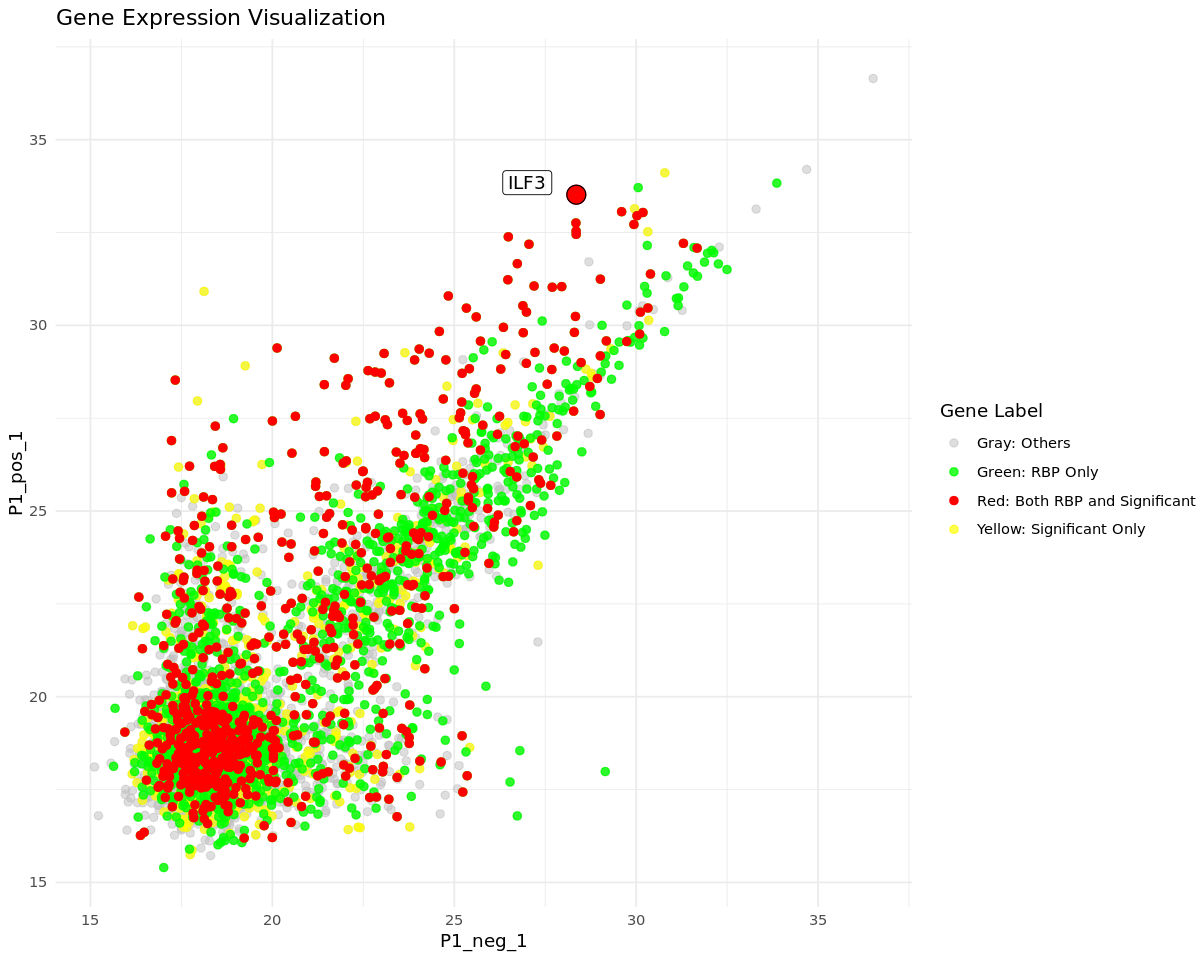

In [26]:
options(repr.plot.width=10, repr.plot.height=8)

green_genes <- Panx1_mspec$EuRBPDB == TRUE
yellow_genes <- Panx1_mspec$P1_neg_vs_P1_pos_significant == TRUE
red_genes <- green_genes & yellow_genes
Panx1_mspec$color <- ifelse(red_genes, "red", ifelse(yellow_genes, "yellow", ifelse(green_genes, "green", "gray")))

ILF3_color = Panx1_mspec[Panx1_mspec$name == "ILF3", ]$color

# Using CF_1 and CF_2 as the axes
ggplot() + 
    geom_point(data = Panx1_mspec, aes(x = P1_neg_1, y = P1_pos_1, color = "gray"), size = 2, alpha = 0.5) + 
    geom_point(data = Panx1_mspec[yellow_genes, ], aes(x = P1_neg_1, y = P1_pos_1, color = "yellow"), size = 2, alpha = 0.7) + 
    geom_point(data = Panx1_mspec[green_genes, ], aes(x = P1_neg_1, y = P1_pos_1, color = "green"), size = 2, alpha = 0.8) + 
    geom_point(data = Panx1_mspec[red_genes, ], aes(x = P1_neg_1, y = P1_pos_1, color = "red"), size = 2, alpha = 1) + 
  
    # Highlight the ILF3 gene 
    geom_point(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P1_neg_1, y = P1_pos_1), color =ILF3_color, size = 5) + 
    geom_point(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P1_neg_1, y = P1_pos_1), color = "black", size = 5, shape = 1) +  # Circle
    geom_label(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P1_neg_1, y = P1_pos_1, label = "ILF3"), fill = NA, hjust = 1.5, vjust = 0) +
    # legend
    scale_color_manual(
        values = c("red" = "red", "green" = "green", "yellow" = "yellow", "gray" = "gray"),
        labels = c("Gray: Others", "Green: RBP Only", "Red: Both RBP and Significant", "Yellow: Significant Only"),
        name = "Gene Label"
    ) +
  
    labs(
        title = "Gene Expression Visualization",
        x = "P1_neg_1",
        y = "P1_pos_1"
    ) +
    theme_minimal()

    # Count gene numbers
    cat("Number of red-labeled genes:", sum(red_genes), "\n")
    cat("Number of green-labeled genes:", sum(green_genes), "\n")
    cat("Number of yellow-labeled genes:", sum(yellow_genes), "\n")

In [29]:
head(Panx1_mspec)

,name,CF_1,CF_2,CF_3,CF_4,CP1_1,CP1_2,CP1_3,CP1_4,CP2_1,⋯,Unknown_5,Unknown_6,Unknown_7,Unknown_8,Unknown_9,Unknown_10,ensembl.id,EuRBPDB,RBPtoGO,color
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
1,Q5VT66,26.79699,27.63969,28.43817,28.44794,28.23361,28.30556,28.31570,28.46855,27.74702,⋯,NA,NA,NA,NA,NA,NA,ENSG00000186205,FALSE,TRUE,gray
2,Q9NVA2,30.75677,31.29329,31.58302,31.50019,31.55673,31.17659,31.66055,30.91592,31.31775,⋯,NA,NA,NA,NA,NA,NA,ENSG00000138758,TRUE,TRUE,green
3,O60613,26.57332,26.62478,26.72884,26.83569,25.31610,25.50963,25.69633,25.30810,25.01419,⋯,NA,NA,NA,NA,NA,NA,ENSG00000183291,FALSE,FALSE,gray
4,Q15019,31.94813,31.89955,32.34236,32.24876,31.99705,31.85013,32.23118,32.35416,31.70512,⋯,NA,NA,NA,NA,NA,NA,ENSG00000168385,FALSE,TRUE,gray
5,Q9UH03,26.97191,27.09778,27.37053,26.80845,26.34394,26.47828,26.36107,27.04062,26.59235,⋯,NA,NA,NA,NA,NA,NA,ENSG00000100167,TRUE,FALSE,green
6,Q9NX47,21.69039,22.01022,25.31565,25.24238,25.17737,26.64650,25.43498,26.88274,25.54483,⋯,NA,NA,NA,NA,NA,NA,ENSG00000198060,FALSE,FALSE,yellow


In [39]:
setwd("/home/ylee/data")

# Extract the gene names based on conditions
P1_upregul_gene_names <- Panx1_mspec$name[Panx1_mspec$P1_neg_vs_P1_pos_significant == TRUE]
P2_upregul_gene_names <- Panx1_mspec$name[Panx1_mspec$P2_neg_vs_P2_pos_significant == TRUE]
W_upregul_gene_names <- Panx1_mspec$name[Panx1_mspec$W_neg_vs_W_pos_significant == TRUE]
F_upregul_gene_names <- Panx1_mspec$name[Panx1_mspec$F_neg_vs_F_pos_significant == TRUE]


# Combine into a list for better organization
gene_categories <- list(
  P1_upregul_genes = P1_upregul_gene_names,
  P2_upregul_genes = P2_upregul_gene_names,
  W_upregul_genes = W_upregul_gene_names,
  F_upregul_genes = F_upregul_gene_names
)

# Save the list to a file
# write.csv(data.frame(Category = "RBP", Name = RBP_gene_names), "/home/ylee/data/Mspec_result/RBP_genes.csv", row.names = FALSE) 
write.csv(data.frame(Category = "P1_upregul", Name = P1_upregul_gene_names), "/home/ylee/data/Mspec_result/P1_upregul_genes.csv", row.names = FALSE)
write.csv(data.frame(Category = "P2_upregul", Name = P2_upregul_gene_names), "/home/ylee/data/Mspec_result/P2_upregul_genes.csv", row.names = FALSE)
write.csv(data.frame(Category = "W_upregul", Name = W_upregul_gene_names), "/home/ylee/data/Mspec_result/W_upregul_genes.csv", row.names = FALSE)
write.csv(data.frame(Category = "F_upregul", Name = F_upregul_gene_names), "/home/ylee/data/Mspec_result/F_upregul_genes.csv", row.names = FALSE)



Number of red-labeled genes: 432 
Number of green-labeled genes: 2113 
Number of yellow-labeled genes: 778 


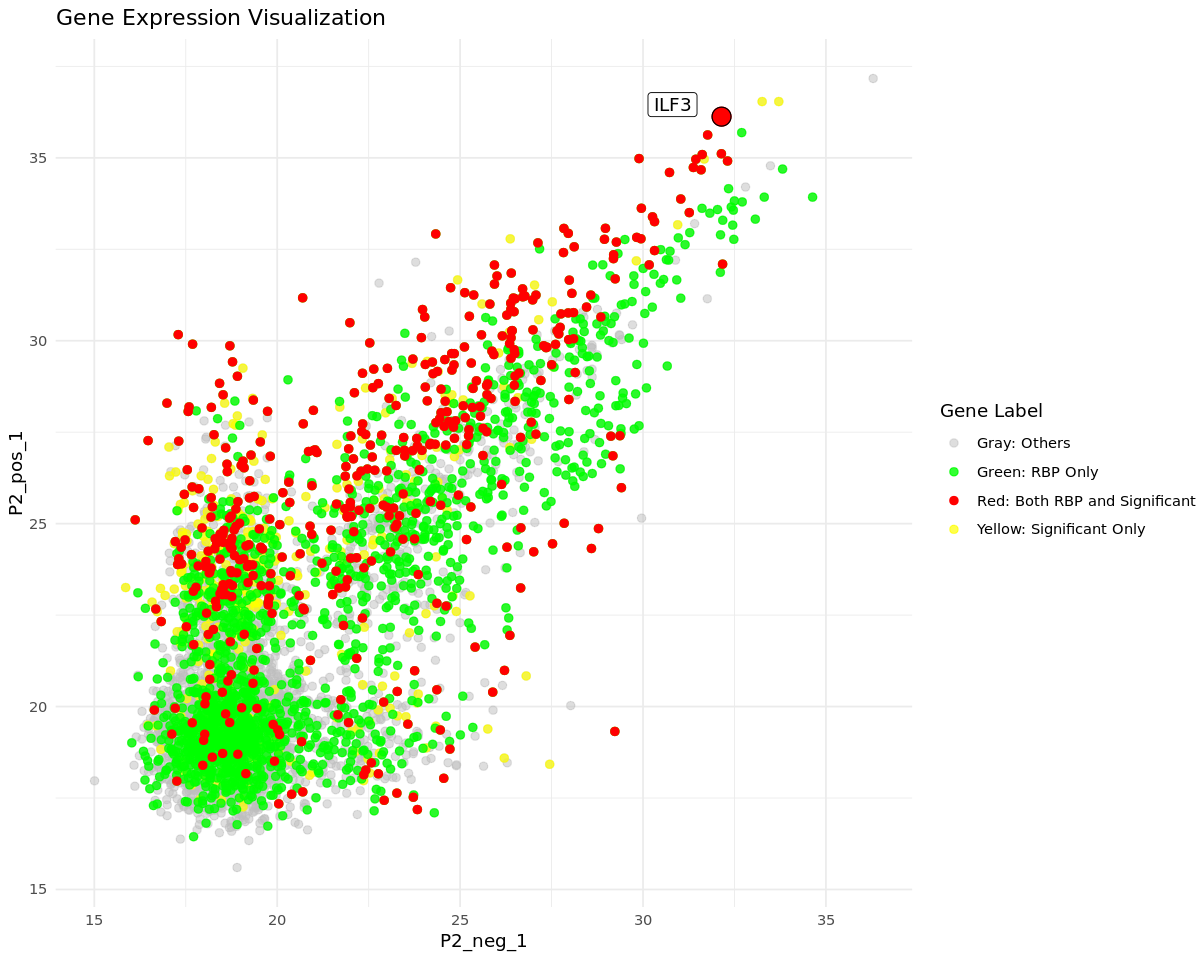

In [226]:
options(repr.plot.width=10, repr.plot.height=8)

green_genes <- Panx1_mspec$EuRBPDB == TRUE
yellow_genes <- Panx1_mspec$P2_neg_vs_P2_pos_significant == TRUE
red_genes <- green_genes & yellow_genes
Panx1_mspec$color <- ifelse(red_genes, "red", ifelse(yellow_genes, "yellow", ifelse(green_genes, "green", "gray")))

ILF3_color = Panx1_mspec[Panx1_mspec$name == "ILF3", ]$color

# Using CF_1 and CF_2 as the axes
ggplot() + 
    geom_point(data = Panx1_mspec, aes(x = P2_neg_1, y = P2_pos_1, color = "gray"), size = 2, alpha = 0.5) + 
    geom_point(data = Panx1_mspec[yellow_genes, ], aes(x = P2_neg_1, y = P2_pos_1, color = "yellow"), size = 2, alpha = 0.7) + 
    geom_point(data = Panx1_mspec[green_genes, ], aes(x = P2_neg_1, y = P2_pos_1, color = "green"), size = 2, alpha = 0.8) + 
    geom_point(data = Panx1_mspec[red_genes, ], aes(x = P2_neg_1, y = P2_pos_1, color = "red"), size = 2, alpha = 1) + 
  
    # Highlight the ILF3 gene 
    geom_point(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P2_neg_1, y = P2_pos_1), color =ILF3_color, size = 5) + 
    geom_point(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P2_neg_1, y = P2_pos_1), color = "black", size = 5, shape = 1) +  # Circle
    geom_label(data = Panx1_mspec[Panx1_mspec$name == "ILF3", ], aes(x = P2_neg_1, y = P2_pos_1, label = "ILF3"), fill = NA, hjust = 1.5, vjust = 0) +
    # legend
    scale_color_manual(
        values = c("red" = "red", "green" = "green", "yellow" = "yellow", "gray" = "gray"),
        labels = c("Gray: Others", "Green: RBP Only", "Red: Both RBP and Significant", "Yellow: Significant Only"),
        name = "Gene Label"
    ) +
  
    labs(
        title = "Gene Expression Visualization",
        x = "P2_neg_1",
        y = "P2_pos_1"
    ) +
    theme_minimal()

    # Count gene numbers
    cat("Number of red-labeled genes:", sum(red_genes), "\n")
    cat("Number of green-labeled genes:", sum(green_genes), "\n")
    cat("Number of yellow-labeled genes:", sum(yellow_genes), "\n")

In [213]:
WT_genes_list <- Panx1_mspec[red_genes, ]$name
length(WT_genes_list)

[1] 450

In [222]:
FLD_genes_list <- Panx1_mspec[red_genes, ]$name
length(FLD_genes_list)

[1] 929

In [225]:
PTC1_genes_list <- Panx1_mspec[red_genes, ]$name
length(PTC1_genes_list)

[1] 710

In [227]:
PTC2_genes_list <- Panx1_mspec[red_genes, ]$name
length(PTC2_genes_list)

[1] 432

In [ ]:
WT_genes_list
FLD_genes_list
PTC1_genes_list
PTC2_genes_list

In [230]:
WT_FLD_intersect <- intersect(WT_genes_list, FLD_genes_list)
WT_PTC1_intersect <- intersect(WT_genes_list, PTC1_genes_list)
WT_PTC2_intersect <- intersect(WT_genes_list, PTC2_genes_list)
FLD_PTC1_intersect <- intersect(FLD_genes_list, PTC1_genes_list)
FLD_PTC2_intersect <- intersect(FLD_genes_list, PTC2_genes_list)
PTC1_PTC2_intersect <- intersect(PTC1_genes_list, PTC2_genes_list)

WT_FLD_PTC1_intersect <- Reduce(intersect, list(WT_genes_list, FLD_genes_list, PTC1_genes_list))
WT_FLD_PTC2_intersect <- Reduce(intersect, list(WT_genes_list, FLD_genes_list, PTC2_genes_list))
WT_PTC1_PTC2_intersect <- Reduce(intersect, list(WT_genes_list, PTC1_genes_list, PTC2_genes_list))
FLD_PTC1_PTC2_intersect <- Reduce(intersect, list(FLD_genes_list, PTC1_genes_list, PTC2_genes_list))

all_common <- Reduce(intersect, list(WT_genes_list, FLD_genes_list, PTC1_genes_list, PTC2_genes_list))

In [232]:
# For pairwise intersections
cat("Number of genes in WT and FLD intersection:", length(WT_FLD_intersect), "\n")
cat("Number of genes in WT and PTC1 intersection:", length(WT_PTC1_intersect), "\n")
cat("Number of genes in WT and PTC2 intersection:", length(WT_PTC2_intersect), "\n")
cat("Number of genes in FLD and PTC1 intersection:", length(FLD_PTC1_intersect), "\n")
cat("Number of genes in FLD and PTC2 intersection:", length(FLD_PTC2_intersect), "\n")
cat("Number of genes in PTC1 and PTC2 intersection:", length(PTC1_PTC2_intersect), "\n")

# For triple intersections
cat("Number of genes in WT, FLD, and PTC1 intersection:", length(WT_FLD_PTC1_intersect), "\n")
cat("Number of genes in WT, FLD, and PTC2 intersection:", length(WT_FLD_PTC2_intersect), "\n")
cat("Number of genes in WT, PTC1, and PTC2 intersection:", length(WT_PTC1_PTC2_intersect), "\n")
cat("Number of genes in FLD, PTC1, and PTC2 intersection:", length(FLD_PTC1_PTC2_intersect), "\n")

# For all common genes
cat("Number of genes in WT, FLD, PTC1, and PTC2 intersection:", length(all_common), "\n")

Number of genes in WT and FLD intersection: 299 
Number of genes in WT and PTC1 intersection: 230 
Number of genes in WT and PTC2 intersection: 258 
Number of genes in FLD and PTC1 intersection: 644 
Number of genes in FLD and PTC2 intersection: 262 
Number of genes in PTC1 and PTC2 intersection: 213 
Number of genes in WT, FLD, and PTC1 intersection: 216 
Number of genes in WT, FLD, and PTC2 intersection: 186 
Number of genes in WT, PTC1, and PTC2 intersection: 151 
Number of genes in FLD, PTC1, and PTC2 intersection: 191 
Number of genes in WT, FLD, PTC1, and PTC2 intersection: 142 


In [233]:
# Function to check if ILF3 is in a gene list
check_ILF3 <- function(gene_list, name) {
  if ("ILF3" %in% gene_list) {
    cat("ILF3 is present in", name, "\n")
  } else {
    cat("ILF3 is NOT present in", name, "\n")
  }
}

# Checking ILF3 in each intersection
check_ILF3(WT_FLD_intersect, "WT and FLD intersection")
check_ILF3(WT_PTC1_intersect, "WT and PTC1 intersection")
check_ILF3(WT_PTC2_intersect, "WT and PTC2 intersection")
check_ILF3(FLD_PTC1_intersect, "FLD and PTC1 intersection")
check_ILF3(FLD_PTC2_intersect, "FLD and PTC2 intersection")
check_ILF3(PTC1_PTC2_intersect, "PTC1 and PTC2 intersection")

check_ILF3(WT_FLD_PTC1_intersect, "WT, FLD, and PTC1 intersection")
check_ILF3(WT_FLD_PTC2_intersect, "WT, FLD, and PTC2 intersection")
check_ILF3(WT_PTC1_PTC2_intersect, "WT, PTC1, and PTC2 intersection")
check_ILF3(FLD_PTC1_PTC2_intersect, "FLD, PTC1, and PTC2 intersection")

check_ILF3(all_common, "WT, FLD, PTC1, and PTC2 intersection")


ILF3 is present in WT and FLD intersection 
ILF3 is present in WT and PTC1 intersection 
ILF3 is present in WT and PTC2 intersection 
ILF3 is present in FLD and PTC1 intersection 
ILF3 is present in FLD and PTC2 intersection 
ILF3 is present in PTC1 and PTC2 intersection 
ILF3 is present in WT, FLD, and PTC1 intersection 
ILF3 is present in WT, FLD, and PTC2 intersection 
ILF3 is present in WT, PTC1, and PTC2 intersection 
ILF3 is present in FLD, PTC1, and PTC2 intersection 
ILF3 is present in WT, FLD, PTC1, and PTC2 intersection 


In [236]:
# Union of PTC1 and PTC2
PTC1_PTC2_union <- union(PTC1_genes_list, PTC2_genes_list)

# Subtract WT genes
red_locus_genes <- setdiff(PTC1_PTC2_union, WT_genes_list)

# Display the list of red-locus genes
print(length(red_locus_genes))
print(red_locus_genes)

[1] 592
  [1] "AAAS"       "AARS2"      "ABCF1"      "ABCF3"      "ACAA2"     
  [6] "ACD"        "ACP1"       "ACSL3"      "ACTN1"      "ADNP"      
 [11] "AGL"        "AGPS"       "AKAP1"      "ANGEL2"     "ANKFY1"    
 [16] "ANP32B"     "ANP32E"     "APEX1"      "API5"       "ARF1"      
 [21] "ARID4A"     "ARL8B"      "ASCC3"      "ATAD2"      "ATL3"      
 [26] "BAZ1A"      "BAZ2A"      "BRD2"       "BRD3"       "BRD4"      
 [31] "BTAF1"      "C18orf21"   "C1orf131"   "CAPN1"      "CARS2"     
 [36] "CBX3"       "CCAR2"      "CCDC12"     "CCDC86"     "CCNK"      
 [41] "CCT6A"      "CDC5L"      "CDK4"       "CEBPZ"      "CENPF"     
 [46] "CEP350"     "CHD7"       "CHORDC1"    "CIZ1"       "CKAP4"     
 [51] "CLK3"       "CMSS1"      "CNN2"       "CNOT3"      "CNP"       
 [56] "COQ3"       "COQ5"       "CORO1B"     "CPNE3"      "CPS1"      
 [61] "CPSF1"      "CPSF3"      "CPSF7"      "CSE1L"      "CSRP2"     
 [66] "CSTF2"      "CSTF3"      "CTR9"       "CUL4B"      "DAP3"     

# Actg1 MassSpec

In [112]:
path1 = "/home/ylee/data/Actg1_model/Full_dataset(WT).csv"
path2 = "/home/ylee/data/Actg1_model/Full_dataset(PTC).csv"
path3 = "/home/ylee/data/Actg1_model/Full_dataset(FLD).csv"

In [113]:
Actg1_WT_mspec <- get_mspec_csv(path1, 12)
Actg1_PTC_mspec <- get_mspec_csv(path2, 11)
Actg1_FLD_mspec <- get_mspec_csv(path3, 12)

In [283]:
head(Actg1_WT_mspec, 10)

,name,WT_pos_1,WT_pos_2,WT_pos_3,WT_1,WT_2,WT_3,WT_neg_1,WT_neg_2,WT_neg_3,⋯,WT_vs_WT_neg_significant,significant,NA,NA.1,NA.2,NA.3,NA.4,NA.5,ensembl.id,RBP_database_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,Q8C650,0,0,0,17.7491099694756,20.568111990676,0,0,0,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,Protein Id not found,FALSE
2,Q8C1B7,21.5098793621729,23.5514510543945,22.7807071575971,22.9990696178907,25.0723063318108,23.821626080712,18.6601073447875,21.3167234662085,19.460559883843,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,ENSMUSG00000058013,TRUE
3,B2RV71,0,0,0,21.8224043383389,22.6620998435549,22.5350702956806,0,0,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,Protein Id not found,FALSE
4,Q8BZR9,20.1686427406263,18.6593060894469,19.8619047345921,22.1188929266762,22.5766707094412,22.2242914318384,0,0,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,ENSMUSG00000020783,TRUE
5,Q9D937,0,0,0,21.8132723385893,22.0349654938164,22.259284672159,0,0,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,ENSMUSG00000071653,FALSE
6,P42208,22.4872620410199,23.4887335533014,21.810490049074,20.5200853360181,24.5302910690008,23.2667087756384,0,21.1235101619457,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,ENSMUSG00000026276,TRUE
7,Q9CPN9,0,18.5909451648001,18.1403105499285,0,19.5896109183079,23.3786187247814,0,23.8729566291321,24.4158356219361,⋯,FALSE,FALSE,NA,NA,NA,NA,NA,NA,ENSMUSG00000029882,FALSE
8,Q9CQE8,0,0,0,18.8525173178383,20.3965504315991,19.2902123864124,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,ENSMUSG00000021807,TRUE
9,Q8CIL4,0,0,0,21.8642723076037,21.3261375864267,22.2820375279929,0,0,0,⋯,TRUE,TRUE,NA,NA,NA,NA,NA,NA,ENSMUSG00000031984,FALSE


In [116]:
head(Actg1_PTC_mspec, 10)

,name,PTC_pos_1,PTC_pos_2,PTC_pos_3,PTC_1,PTC_2,PTC_3,PTC_neg_1,PTC_neg_2,PTC_neg_3,⋯,PTC_pos_vs_PTC_significant,PTC_pos_vs_PTC_neg_significant,PTC_vs_PTC_neg_significant,significant,NA,NA.1,NA.2,NA.3,NA.4,NA.5
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Q8C1B7,0,22.1865555813713,22.845597244496,21.5754709246016,26.2441066883588,23.9791942011584,0,20.0733936990242,0,⋯,FALSE,FALSE,FALSE,FALSE,NA,NA,NA,NA,NA,NA
2,B2RV71,0,0,0,0,23.6386515610959,22.344729344915,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
3,Q8BZR9,0,20.3194824937101,0,0,25.0929322728854,21.9075655269406,0,0,0,⋯,FALSE,FALSE,FALSE,FALSE,NA,NA,NA,NA,NA,NA
4,Q9D937,0,0,0,19.9181906596274,25.3068165680099,22.9774483365527,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
5,P42208,20.4068610193607,22.0251287454865,21.7808072620276,22.7426490739859,25.9105420925399,24.2873601160778,0,19.2796196486467,17.4477451277222,⋯,FALSE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
6,Q9CPN9,17.1241415107111,22.3447022589172,0,23.8297769218329,0,23.2745499162656,0,23.0493965731517,19.0651057922723,⋯,FALSE,FALSE,FALSE,FALSE,NA,NA,NA,NA,NA,NA
7,Q9CQE8,0,0,0,0,22.1383368047925,20.75662147166,0,0,0,⋯,0.042189571505952,0.0289060774512191,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA
8,Q8CIL4,0,0,0,0,23.8603178757408,22.6884210725873,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
9,O55131,20.3708193504356,23.2085862381578,23.2247477410127,23.3056342875467,26.8140893512135,25.5838829631179,0,22.4289510050606,20.3564906575349,⋯,FALSE,FALSE,FALSE,FALSE,NA,NA,NA,NA,NA,NA


In [117]:
head(Actg1_FLD_mspec, 10)

,name,FLD_pos_1,FLD_pos_2,FLD_pos_3,FLD_1,FLD_2,FLD_3,FLD_neg_1,FLD_neg_2,FLD_neg_3,⋯,FLD_pos_vs_FLD_significant,FLD_pos_vs_FLD_neg_significant,FLD_vs_FLD_neg_significant,significant,NA,NA.1,NA.2,NA.3,NA.4,NA.5
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Q8C650,0,0,0,26.0470180423419,26.710040003524,23.9238838211854,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
2,Q8C1B7,24.3444178252343,21.7898281269441,23.4631371781391,30.367967806007,30.7188998128206,29.6857044720745,24.2219929731895,23.0319239416477,23.2111884355924,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
3,B2RV71,0,0,0,25.4473945393657,25.1502335110217,25.6900050072833,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
4,Q8BZR9,23.3063298639745,20.4102815717659,21.6357322887781,27.5526680422595,28.5042687958115,27.9862000181071,0,0,0,⋯,TRUE,TRUE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
5,Q9D937,20.4256257016379,0,0,26.8902952676357,27.9570957518973,27.4421349587729,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
6,P42208,24.6282301422427,21.8102546799503,23.6216503753077,30.2859281605847,30.8513257620384,30.1319767953501,24.071610968372,22.4891747144684,23.7149204489982,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
7,Q9CPN9,0,0,0,24.2002275243518,24.0713654659395,23.0226590428659,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA
8,Q9CQE8,20.7641750787146,17.9546961496161,19.9647977301093,28.357581669223,29.3117482110847,28.5451002222421,0,0,0,⋯,5.63373137679083e-09,2.1639080204247e-09,TRUE,TRUE,TRUE,TRUE,NA,NA,NA,NA
9,Q8CIL4,0,0,0,27.3909182143235,26.5394314721554,27.2867434479595,0,0,0,⋯,TRUE,FALSE,TRUE,TRUE,NA,NA,NA,NA,NA,NA


In [299]:
Actg1_WT_mspec <- get_mspec_with_ensembl_id("mouse", Actg1_WT_mspec)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [300]:
Actg1_PTC_mspec <- get_mspec_with_ensembl_id("mouse", Actg1_PTC_mspec)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [301]:
Actg1_FLD_mspec <- get_mspec_with_ensembl_id("mouse", Actg1_FLD_mspec)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [302]:
Actg1_WT_mspec <- get_mspec_with_rbp_info("EuRBPDB", EuRBPDB_M, Actg1_WT_mspec)
Actg1_WT_mspec <- get_mspec_with_rbp_info("RBPtoGO", RBPtoGO_M, Actg1_WT_mspec)

Actg1_PTC_mspec <- get_mspec_with_rbp_info("EuRBPDB", EuRBPDB_M, Actg1_PTC_mspec)
Actg1_PTC_mspec <- get_mspec_with_rbp_info("RBPtoGO", RBPtoGO_M, Actg1_PTC_mspec)

Actg1_FLD_mspec <- get_mspec_with_rbp_info("EuRBPDB", EuRBPDB_M, Actg1_FLD_mspec)
Actg1_FLD_mspec <- get_mspec_with_rbp_info("RBPtoGO", RBPtoGO_M, Actg1_FLD_mspec)

EuRBPDB RBP numbers : 866 out of 1392 mspec data
RBPtoGO RBP numbers : 1046 out of 1392 mspec data
EuRBPDB RBP numbers : 886 out of 1452 mspec data
RBPtoGO RBP numbers : 1073 out of 1452 mspec data
EuRBPDB RBP numbers : 1028 out of 1786 mspec data
RBPtoGO RBP numbers : 1240 out of 1786 mspec data
